# Trying vector codings 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

In [2]:
length_of_protein = 100
num_mutated = 4
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, \
                                mut_probs = [[0.1, 0.1], [0.05, 0.05, 0.1], [0.05, 0.05, 0.1], [0.1, 0.1]], parent_prob=0.80) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 

Parent protein: VSQANYSVTQYCITAMSMMNRGLCEEPVKQRENLSNEERNIDGMRRPHHAIFSLDVIHQVLRTGTGEQPLGTERTFQYCRILYPCHYYRPRGWFDDSIGE
Random mutaed positions [10 32 63 87]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


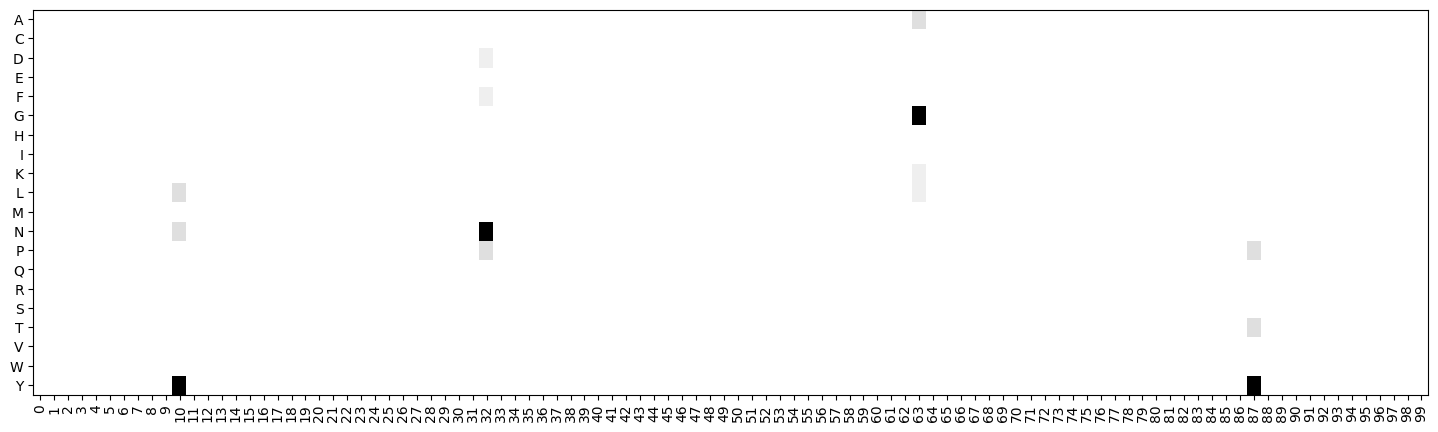

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)
seqs = np.unique(seqs)
probs = S.compute_prob_n_mutations(num_mutated+1)

In [5]:
S.mutation_probs_variable_region_indexed

defaultdict(None,
            {0: {'L': 0.1, 'N': 0.1, 'Y': 0.8},
             1: {'D': 0.05, 'F': 0.05, 'N': 0.8, 'P': 0.1},
             2: {'A': 0.1, 'G': 0.8, 'K': 0.05, 'L': 0.05},
             3: {'P': 0.1, 'T': 0.1, 'Y': 0.8}})

# Now you have variable length mat to create encoder 

In [6]:
from doe_utils import Encoding_basics

class Sequence_encoder_simplex(Encoding_basics): 
    """
    This encodes in variable length codes, to get rid of null space, one hot simplex 
    """
    def __init__(self, mutation_probs_variable_region_dict): 
        """
        Args:
            mutated_region_length: the length of ONLY the variable region (mutated region) of the protein, NOT the whole protein length! 
        """
        super().__init__(mutation_probs_variable_region_dict) 
        
    def encode_seqs(self, protein_seqs): 
        """
        Args: 
            protein_seqs: this is only the variable region 
        """
        independent_codes = [] 
        pairwise_codes = [] 
        for seq in protein_seqs:
            array_of_seq = np.asarray(list(seq))
            assert len(seq) == self.mutated_region_length, "length mismatch of protein seq and attributes"
            
            local_code_I = [x*0 for x in self.independent_codes_list] # initialize to zero 
            for i in range(self.mutated_region_length): 
                feature = str(i) + '-' + array_of_seq[i] 
                index = list(self.feature_names_independent).index(feature) 
                print(index)
                local_code_I[index] = self.independent_codes_list[index] 
                print(self.independent_codes_list[index])
            independent_codes.append(local_code_I)   
            
            local_code_J = [x*0 for x in self.pairwise_codes_list]
            for j, pos in enumerate(self.pos_product): 
                # need to find the index of amino_acid pairs 
                amino_pairs = array_of_seq[pos]
                feature = str(pos[0]) + '-' + amino_pairs[0] + ':' + str(pos[1]) + '-' + amino_pairs[1]
                index = list(self.feature_names_pairwise).index(feature)
                local_code_J[index] = self.pairwise_codes_list[index]
            pairwise_codes.append(local_code_J) 
        return independent_codes, pairwise_codes


#######################################################################################################

class Create_in_silico_model(Encoding_basics): 
    """
    Create an in silico model for simulation with independent and pairwise contributions 
    """
    def __init__(self, mutation_probs_variable_region_dict, independent_params = None, pairwise_params = None, baseline = 10): 
        """
        Args:
            mutation_probs ..  : pass the dict of mutation probs (this is generated by SOLD matrix class, attribute dict is called mutation_probs_variable_region_indexed) 
            MUST BE INDEXED BY THE POSITION OF THE MUTATED REGION, not the protein position... this is to make sure we can deal with different length proteins 
                example:
                {0: {'D': 0.05, 'K': 0.85, 'M': 0.05, 'Y': 0.05},
                 1: {'C': 0.05, 'G': 0.05, 'I': 0.05, 'P': 0.85},
                 2: {'F': 0.05, 'N': 0.05, 'R': 0.85, 'Y': 0.05},
                 3: {'G': 0.05, 'I': 0.05, 'L': 0.85, 'Q': 0.05},
                 4: {'A': 0.05, 'E': 0.05, 'R': 0.05, 'W': 0.85},
                 5: {'A': 0.05, 'D': 0.05, 'I': 0.85, 'K': 0.05}}
                where the keys are the index of the mutated regions and the values are dicts of probs of each amino acid
            idependent_params: {'rho':[0.2, 0.2], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
            pairwise_params: {'rho':[0.1, 0.1], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 
            
        """
        # independent params pdf default --- 
        I_defaults = {'rho':[0.2, 0.2], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
        #pairwise params pdf default ---
        P_defaults = {'rho':[0.2, 0.2], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 

        super().__init__(mutation_probs_variable_region_dict) 

        if independent_params is not None: 
            I_defaults.update(independent_params) 
        self.independent_params = I_defaults.copy()  

        if pairwise_params is not None: 
            P_defaults.update(pairwise_params) 
        # see the create mixture function
        self.pairwise_params = P_defaults.copy() 
        
        # Now I need to assign weights to individual and pairwise contributions 
        # first fill in the weights for the independent codes
        self.Prob_I = Create_mixture(**self.independent_params)
        samples_I, _ = self.Prob_I.samples(np.prod(self.shape_independent_weights))
        self.independent_weights = samples_I.reshape(self.shape_independent_weights)         
        self.Prob_P = Create_mixture(**self.pairwise_params)
        samples_P, _ = self.Prob_P.samples(np.prod(self.shape_pairwise_weights))
        self.pairwise_weights = samples_P.reshape(self.shape_pairwise_weights)              
        self.baseline = baseline    
    
    def model(self, independent_codes, pairwise_codes): 
        """
        Args: 
            independent_codes: the result of encoding my sequence encoder to independent codes --- these are tensors--- N seqs times A amino acids time L positions (shape_independet_weights) etc. 
            pairwise_codes: similar 
            masked: ignore the weights of independent and pairwise positions that are not variable! 
        """
        ans1 = np.einsum('ijk, jk -> i', independent_codes, self.independent_weights) 
        ans2 = np.einsum('ijk, jk -> i', pairwise_codes, self.pairwise_weights)
        return self.baseline + ans1 + ans2 
        
    def plot_weights(self): 
        """
        Plotting functions 
        """
        # weights 
        I_samples = np.ravel(self.independent_weights) 
        GRID_SIZE = 1000
        x = np.linspace(np.min(I_samples), np.max(I_samples), GRID_SIZE)
        plt.figure() 
        plt.plot(x, self.Prob_I.pdf()(x))
        _ = plt.hist(I_samples, density=True, bins = 50)        
        plt.title('Distribution of independent weights') 

        P_samples = np.ravel(self.pairwise_weights) 
        x = np.linspace(np.min(P_samples), np.max(P_samples), GRID_SIZE)
        plt.figure() 
        plt.plot(x, self.Prob_P.pdf()(x))
        _ = plt.hist(P_samples, density=True, bins = 50)        
        plt.title('Distribution of pairwise weights') 
        plt.figure() 
        plt.imshow(self.independent_weights, vmin = -1, vmax = 1, cmap = 'RdBu', interpolation = 'None') 
        _  = plt.yticks(range(len(self.feature_names_independent)), self.feature_names_independent)
        _  = plt.xticks(range(self.shape_independent_weights[1]))
        plt.title("Independent weights") 
        plt.colorbar() 
        plt.figure(figsize = (5, 70))
        plt.imshow(self.pairwise_weights, vmin = -1, vmax = 1, cmap = 'RdBu', aspect = 'auto', interpolation = 'None') 
        _  = plt.yticks(range(len(self.feature_names_pairwise)), self.feature_names_pairwise)
        _  = plt.xticks(range(self.shape_pairwise_weights[1]))
        plt.title("Pairwise weights") 
        #plt.colorbar



In [7]:
Q = doe_utils.Encoding_basics(S.mutation_probs_variable_region_indexed)

In [8]:
Q.feature_names_independent

['0-L',
 '0-N',
 '0-Y',
 '1-D',
 '1-F',
 '1-N',
 '1-P',
 '2-A',
 '2-G',
 '2-K',
 '2-L',
 '3-P',
 '3-T',
 '3-Y']

In [9]:
Q.code_length_pairwise

np.int64(840)

In [10]:
Q.independent_codes_list

[array([1., 0.]),
 array([0., 1.]),
 array([0., 0.]),
 array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 1.]),
 array([1., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 0.])]

In [11]:
Q.feature_names_independent

['0-L',
 '0-N',
 '0-Y',
 '1-D',
 '1-F',
 '1-N',
 '1-P',
 '2-A',
 '2-G',
 '2-K',
 '2-L',
 '3-P',
 '3-T',
 '3-Y']

In [12]:
E = Sequence_encoder_simplex(S.mutation_probs_variable_region_indexed)
A, B = E.encode_seqs(seqs[:3])

0
[1. 0.]
3
[1. 0. 0.]
7
[1. 0. 0.]
11
[1. 0.]
0
[1. 0.]
3
[1. 0. 0.]
7
[1. 0. 0.]
12
[0. 1.]
0
[1. 0.]
3
[1. 0. 0.]
7
[1. 0. 0.]
13
[0. 0.]


In [13]:
S.parent

{10: 'Y', 32: 'N', 63: 'G', 87: 'Y'}

In [14]:
seqs[0]

np.str_('LDAP')

In [15]:
A[0]

[array([1., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([1., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([1., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([1., 0.]),
 array([0., 0.]),
 array([0., 0.])]

In [16]:
Q.feature_names_independent

['0-L',
 '0-N',
 '0-Y',
 '1-D',
 '1-F',
 '1-N',
 '1-P',
 '2-A',
 '2-G',
 '2-K',
 '2-L',
 '3-P',
 '3-T',
 '3-Y']

In [17]:
np.asarray(Q.feature_names_pairwise)[np.asarray([np.any(a) for a in B[0]])]

array(['0-L:1-D', '0-L:2-A', '0-L:3-P', '1-D:2-A', '1-D:3-P', '2-A:3-P'],
      dtype='<U7')

In [18]:
seqs[0]

np.str_('LDAP')

In [19]:
Q.parent

'YNGY'